In [2]:
import torch, sys
sys.path.append('/home/dgotzens/scripts')
from timedataparser import load_all
import pdfdefaults as pdf
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.dates import DateFormatter
import tools

date='23-10-09'
header,time,data,temperature,reboots = load_all(f'/home/dgotzens/recording/{date}/', True)
M,K,L = data.shape
maxdist = 25
N = 2**10
torch.Tensor.dB = lambda self: 20*(self).log10()
torch.Tensor.dBr = lambda self: (self/self.max()).dB()

# heatup = data[:,:,:9*60]
# t_heatup = time[:9*60]
# static = data[:,:,15*60:]
# t_static = time[15*60:]


loaded data with shape torch.Size([1022, 192, 983])


In [2]:
pdf.setup()
plt.figure(layout='constrained')
window = torch.hann_window(M)
fft = torch.fft.fft(window[:,None,None]*data[:,:,:200], dim=0, n=N)
R = torch.linspace(0,maxdist,N)
plt.plot(R,fft.abs().mean((1,2)).dBr())
plt.gca().xaxis.set_major_formatter(EngFormatter('m'))
plt.gca().yaxis.set_major_formatter(EngFormatter('dBr'))
plt.grid()
plt.gcf().set_size_inches(0.45*pdf.a4_textwidth, 0.45*pdf.a4_textwidth)
# plt.show()
plt.savefig('/home/dgotzens/thesis/figures/interference.pdf')

plt.figure(layout='constrained')
nmax = torch.tensor([l for l,r in enumerate(R) if r<3]).argmax()
plt.plot(R[:nmax],fft[:nmax,:,:].abs().mean((1,2)).dBr())
plt.gca().xaxis.set_major_formatter(EngFormatter('m'))
plt.gca().yaxis.set_major_formatter(EngFormatter('dBr'))
plt.grid()
plt.gcf().set_size_inches(0.45*pdf.a4_textwidth, 0.45*pdf.a4_textwidth)
# plt.show()
plt.savefig('/home/dgotzens/thesis/figures/interference_zoom.pdf')

In [14]:
reflpos = []
window = torch.hann_window(M)
N=2**16
nmin, nmax = int(1.4*N/maxdist), int(2*N/maxdist)
for l in range(L):
    fft = torch.fft.fft(window[:,None]*data[:,:,l], dim=0, n=N)
    n = fft[nmin:nmax,:].abs().mean(1).argmax(0) + nmin
    reflpos.append(float(n/N * maxdist))


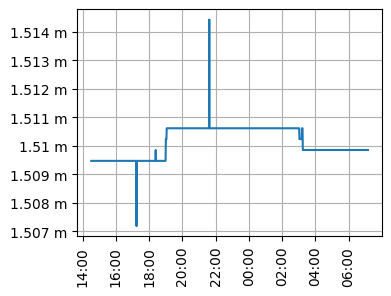

In [15]:
# %matplotlib inline
plt.figure(layout='constrained')
plt.plot(time,reflpos)
plt.gca().yaxis.set_major_formatter(EngFormatter('m'))
plt.gca().xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=90)
plt.grid()
# plt.ylim(1.509,1.512)
plt.gcf().set_size_inches(0.6*pdf.a4_textwidth, 0.45*pdf.a4_textwidth)
# plt.show()
plt.savefig('/home/dgotzens/thesis/figures/refldist.pdf')

In [40]:
N=2**17
window = torch.hann_window(M)
Lh = heatup.shape[-1]
drift = torch.zeros((K,Lh), dtype=torch.cfloat)
fig, ax = plt.subplots(3, sharex=True)
nmin, nmax = int(0.8*N/maxdist), int(1.2*N/maxdist)
for k in range(K):
    fft = torch.fft.fft(window[:,None]*heatup[:,k,:], n=N, dim=0)
    n = fft[nmin:nmax,:].abs().argmax(0) + nmin
    drift[k,:] = fft[n,range(Lh)] / fft[n[0],0]
    ax[0].plot(t_heatup, drift[k,:].abs().dB(), 'k-', linewidth=0.1)
    ax[1].plot(t_heatup, tools.unwrap(drift[k,:].angle())*180/torch.pi, 'k-', linewidth=0.1)
ax[0].plot(t_heatup, drift.abs().mean(0).dB(), linewidth=1)
ax[1].plot(t_heatup, 180/torch.pi*tools.unwrap(drift.angle(),dim=1).mean(0), linewidth=1)

cmap = plt.get_cmap('tab10')
for n,key in enumerate(temperature.keys()):
    stamps = list(temperature[key].keys())[:9*60]
    temps = list(temperature[key].values())[:9*60]
    ax[2].plot(stamps, [t*1e-3 for t in temps], color=cmap(n), label=key)

ax[0].set_ylabel('Level Drift [dB]')
ax[1].set_ylabel('Phase Drift [°]')
ax[2].set_ylabel('System Temperature [°C]')

ax[2].set_ylim(30,70)
ax[2].legend()
ax[2].set_xlabel('Time')
ax[2].xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=90)
for k in range(3):
    ax[k].grid()
fig.savefig(f'/home/dgotzens/thesis/figures/meas_{date}_phase_drift_heatup.pdf')

In [30]:
N=2**15
window = torch.hann_window(M)
Ls = static.shape[-1]
drift = torch.zeros((K,Ls), dtype=torch.cfloat)
fig, ax = plt.subplots(3, sharex=True)
nmin, nmax = int(0.8*N/maxdist), int(1.2*N/maxdist)
for k in range(K):
    fft = torch.fft.fft(window[:,None]*static[:,k,:], n=N, dim=0)
    n = fft[nmin:nmax,:].abs().argmax(0) + nmin
    drift[k,:] = fft[n,range(Ls)] / fft[n[0],0]
    ax[0].plot(t_static, drift[k,:].abs().dB(), 'k-', linewidth=0.1)
    ax[1].plot(t_static, tools.unwrap(drift[k,:].angle())*180/torch.pi, 'k-', linewidth=0.1)
ax[0].plot(t_static, drift.abs().mean(0).dB(), linewidth=1)
ax[1].plot(t_static, 180/torch.pi*tools.unwrap(drift.angle(),dim=1).mean(0), linewidth=1)

cmap = plt.get_cmap('tab10')
for n,key in enumerate(temperature.keys()):
    stamps = list(temperature[key].keys())[15*60:]
    temps = list(temperature[key].values())[15*60:]
    ax[2].plot(stamps, [t*1e-3 for t in temps], color=cmap(n), label=key)

ax[0].set_ylabel('Level Drift [dB]')
ax[1].set_ylabel('Phase Drift [°]')
ax[2].set_ylabel('System Temperature [°C]')

ax[2].set_ylim(30,70)
ax[2].legend()
ax[2].set_xlabel('Time')
ax[2].xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=90)
for k in range(3):
    ax[k].grid()
# plt.show()
fig.savefig(f'/home/dgotzens/thesis/figures/meas_{date}_phase_drift_static.pdf')

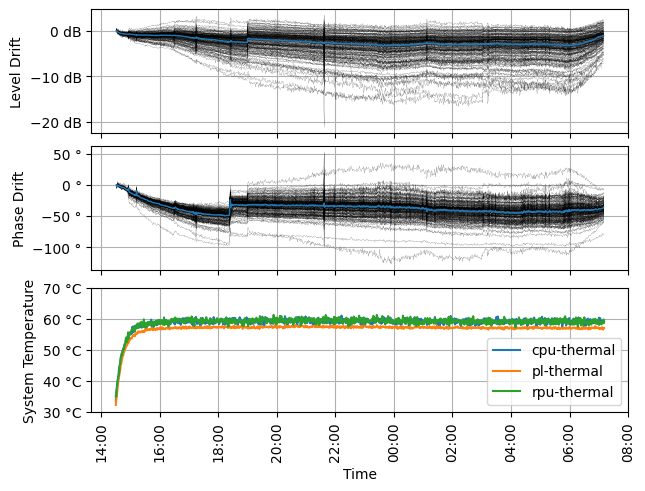

In [4]:
N=2**12
window = torch.hann_window(M)
drift = torch.zeros((K,L), dtype=torch.cfloat)
fig, ax = plt.subplots(3, sharex=True, layout='constrained')
nmin, nmax = int(1.4*N/maxdist), int(2*N/maxdist)
fft = torch.fft.fft(window[:,None,None]*data, n=N, dim=0)
n = fft.mean(1).abs()[nmin:nmax,:].argmax(0) + nmin

for k in range(K):
    drift[k,:] = fft[n,k,range(L)] / fft[n[0],k,0]
    ax[0].plot(time, drift[k,:].abs().dB(), 'k-', linewidth=0.1)
    ax[1].plot(time, 180/torch.pi*tools.unwrap(drift[k,:].angle()), 'k-', linewidth=0.1)
ax[0].plot(time, drift.abs().mean(0).dB(), linewidth=1)
ax[1].plot(time, 180/torch.pi*tools.unwrap(drift.angle(),dim=1).mean(0), linewidth=1)

cmap = plt.get_cmap('tab10')
for n,key in enumerate(temperature.keys()):
    stamps = list(temperature[key].keys())
    temps = list(temperature[key].values())
    ax[2].plot(stamps, [t*1e-3 for t in temps], color=cmap(n), label=key)

ax[0].set_ylabel('Level Drift')
ax[0].yaxis.set_major_formatter(EngFormatter('dB'))
ax[1].set_ylabel('Phase Drift')
ax[1].yaxis.set_major_formatter(EngFormatter('°'))
ax[2].set_ylabel('System Temperature')
ax[2].yaxis.set_major_formatter(EngFormatter('°C'))

ax[2].set_ylim(30,70)
ax[2].legend()
ax[2].set_xlabel('Time')
ax[2].xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=90)
for k in range(3):
    ax[k].grid()
# plt.show()
fig.set_figwidth(pdf.a4_textwidth)
fig.savefig(f'/home/dgotzens/thesis/figures/meas_{date}_phase_drift.pdf')